In [1]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy import signal
from helpers import *
import matplotlib

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})
fs=44100

# Pitch control

Let's start by implementing Pitch control, that straight-forwardly consists in resampling the signal while keeping the lecture sample rate the same.

In [2]:
def pitch_control(x, r):
    """Simple pitch control.
    
    x: input signal
    r: ratio of the time and pitch modification
    """
    return signal.resample(x, int(x.size/r))

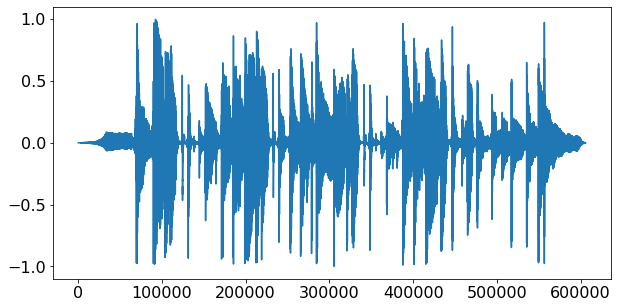

In [3]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.plot(guitar_sample)
Audio("samples/guitar.wav", autoplay=False)

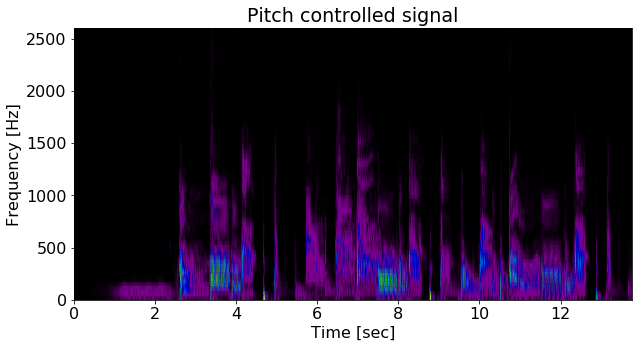

In [4]:
guitar_pitched = pitch_control(guitar_sample, 0.6)

# Plot
f, t, Zxx = signal.stft(guitar_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig("guitar_STFT.png", dpi=150, bbox_inches='tight')
plt.show()

f, t, Zxx = signal.stft(guitar_pitched[:guitar_sample.size], fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch controlled signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig("pitch_control.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
wavfile.write('samples/guitar_pitched.wav', fs, (0x7FFF * guitar_pitched).astype(np.int16))
Audio("samples/guitar_pitched.wav", autoplay=False)

The signal is stretched both vertically and horizontally. 

# Time stretching

Let's now implement the time streching effect, implemented using a Phase Vocoder. Here, each STFT is first cut with a selected window size and overlapping size, then phase corrected in frequency domain to match the previous chunk's phase, and finally put back together with a different overlapping amount than when cutting the chunks. Larger overlaps make the final duration shorter!

In [5]:
def PV_stretch(x, r, w=2048, h_in=512):
    """Time strech using a phase vocoder
    Inspired from an implementation by Zulko: http://zulko.github.io
    
    x: input signal
    r: time modification ratio
    w: window size
    h_in: input hop size (samples between 2 windows' start times)
    """

    phase  = np.zeros(w) # init
    hanning_window = np.hanning(w) # We use a hanning window
    result = np.zeros( int(x.size /r + w)) # Output placeholder

    # Windowing the signal 
    for i in np.arange(0, x.size-(w+h_in), int(h_in*r)):

        # Get 2 chunks at the time (first for phase, second will be edited)
        chunk1 = x[i: i + w]
        chunk2 = x[i + h_in: i + w + h_in]

        # Analysis section (go to freq-domain and obtain the frequencies of the chucks)
        freqs1 =  fft(hanning_window * chunk1)
        freqs2 =  fft(hanning_window * chunk2)
        
        # Frequency-domain transformation
        instant_phase =  np.angle(freqs2/freqs1) # Obtain the instantaneous phase of chunk2
        phase += instant_phase # Add to the previous phase (no wrapping in [0:2pi) )
        freqs2_rephased = np.abs(freqs2)*np.exp(1j*phase) # Replace chunk2's phase with this new one
        
        # Synthesis section (back to time-domain)
        chunk2_rephased = np.real(ifft( freqs2_rephased ))

        # Overlap-add section (with different hop size)
        h_out = int(i/r) # output hop size
        result[h_out : h_out + w] += hanning_window*chunk2_rephased # Add this window to result

    return result / np.max(np.abs(result) ) # Normalize

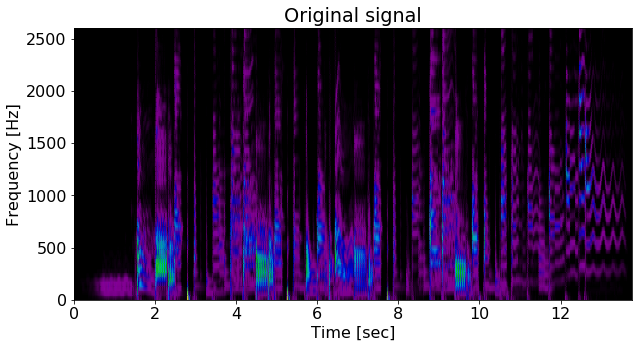

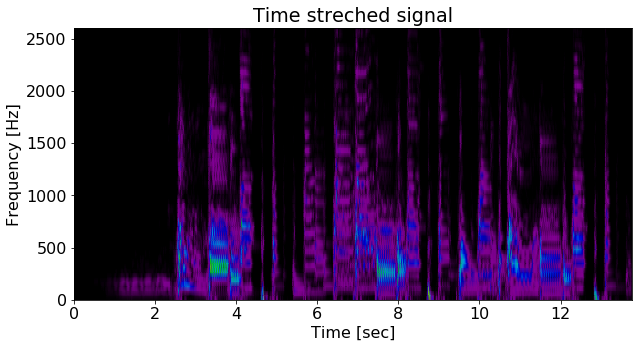

In [7]:
guitar_streched = PV_stretch(guitar_sample, 0.6)

# Plot
f, t, Zxx = signal.stft(guitar_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(guitar_streched[:guitar_sample.size], fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Time streched signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig("time_stretch.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
wavfile.write('samples/guitar_streched.wav', fs, (0x7FFF * guitar_streched).astype(np.int16))
Audio("samples/guitar_streched.wav", autoplay=False)

Note the light echo, or buzzing artifact induced by the adding phase of the algorithm! Time time, the STFT of the signal has the same scale vertically, but is stretched horizontally. The frequency are hence preserved, while the duration is altered.

# Pitch scaling

A pitch-scale is achievable by combining a time-stretch and a pitch control in series! The order between the 2 transformation is different based on the ratio, in order to minimize the number of computations.

In [8]:
def PV_pitch(x, r, w=2048, h=512):
    """
    Pitch-scaler using a combination of time stretch and pitch control.
    """
    # We use a different combination order depending on the ratio, in order to always deal with the shorter signals and gain time.
    if(r>=1): # When the ratio>1, pitch-control up first, to get a shorter signal, and then stretch it longer.
        return PV_stretch( pitch_control(x, r), 1/r, w, h)
    else: # When the ratio<1, start by streching the signal shorter, and then pitch-control it down.
        return pitch_control( PV_stretch(x, 1/r, w, h), r)

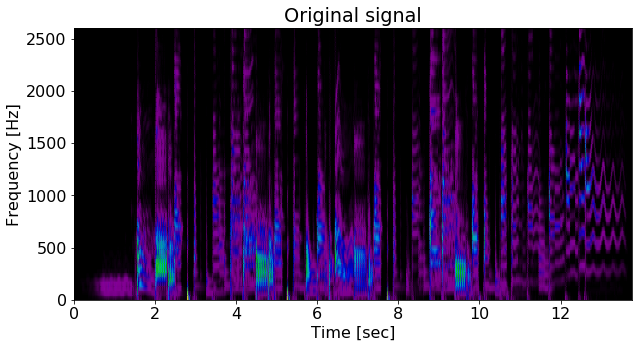

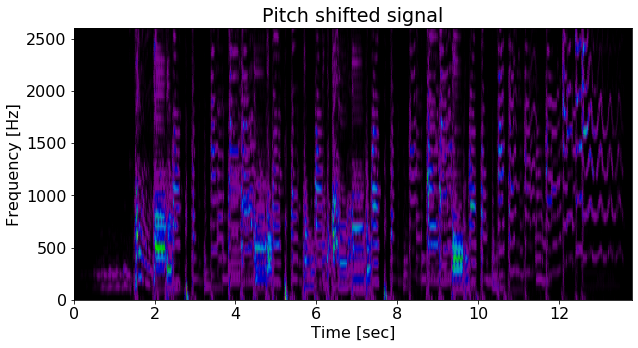

In [11]:
guitar_pitched = PV_pitch(guitar_sample, 1.5)

# Plot
f, t, Zxx = signal.stft(guitar_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(guitar_pitched, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig("time_scale.png", dpi=150, bbox_inches='tight')
plt.show()

# Write to disk
wavfile.write('samples/guitar_pitched.wav', fs, (0x7FFF * guitar_pitched).astype(np.int16))
Audio("samples/guitar_pitched.wav", autoplay=False)

This time the horizontal scale is untouched, but the vertical scale is stretched. The duration is unchanged but the frequencies have increased!